In [1]:
#Meir's Notebook

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from yellowbrick.regressor import ResidualsPlot
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
%matplotlib inline

In [3]:
# Reading in the data set into varialbe housing_df and changing the 2nd column into datetime
housing_df = pd.read_csv('./data/kc_house_data.csv', parse_dates=[1])

In [4]:
# Looking at the dataframe to see the overall data organization 
pd.set_option('display.max_columns', None)
housing_df.head()
# Decided to keep id column for future reference, in case of new data addition, as well as checking for duplicates. 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
# Checking data type of each column
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  object        
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

In [6]:
housing_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [7]:
# Checking to see if any columns have NaN values
housing_df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [8]:
((housing_df.view.isna().sum())/(len(housing_df.view))) * 100

0.29170718155299347

In [9]:
((housing_df.yr_renovated.isna().sum())/((len(housing_df.yr_renovated)))) * 100

17.78950780200954

In [10]:
ren_col = housing_df[['yr_renovated']]
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer.fit(ren_col)
ren_imputed = imputer.transform(ren_col)
housing_df.yr_renovated = ren_imputed

In [11]:
((housing_df.waterfront.isna().sum())/(len(housing_df.waterfront))) * 100

11.00152798999861

In [12]:
#Deal with duplicated `id`
#Add `resold_id` column, where first occurrence = 0 and later occurrences = 1

In [13]:
housing_df['grade'] = housing_df['grade'].str[0:2].str.strip().astype(int)

In [14]:
#dict_replace = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
#housing_df['condition'] = housing_df['condition'].replace(dict_replace)

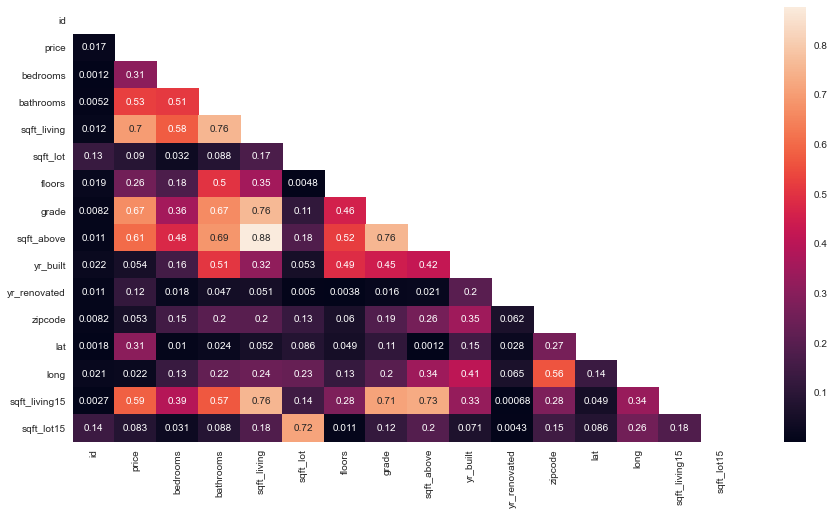

In [15]:
corr = abs(housing_df.corr())
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), annot=True);

# We can see that sqft_above is collinear with sqft_living. 
# That's why we can replace sqft_above with boolean for new column 'basement'
# We also see collinearity between sqft_living and grade. square footage is numeric and continuous,
# easier to use than grade. We can drop grade.
# sqft_living is highest correlation to price 

In [16]:
# feature engineering
# Age of home when sold
housing_df['year_sold'] = housing_df['date'].dt.year
housing_df['age_when_sold'] = housing_df['year_sold'] - housing_df['yr_built']

In [17]:
# feature engineering 
housing_df['sqft_basement'] = housing_df['sqft_living'] - housing_df['sqft_above']
housing_df['basement'] = housing_df['sqft_basement'].map(lambda x: True if x > 0 else False)
housing_df['basement'] = housing_df['basement'].astype(int)

In [18]:
numerical_df = housing_df[['price','bedrooms','bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'age_when_sold' ]]

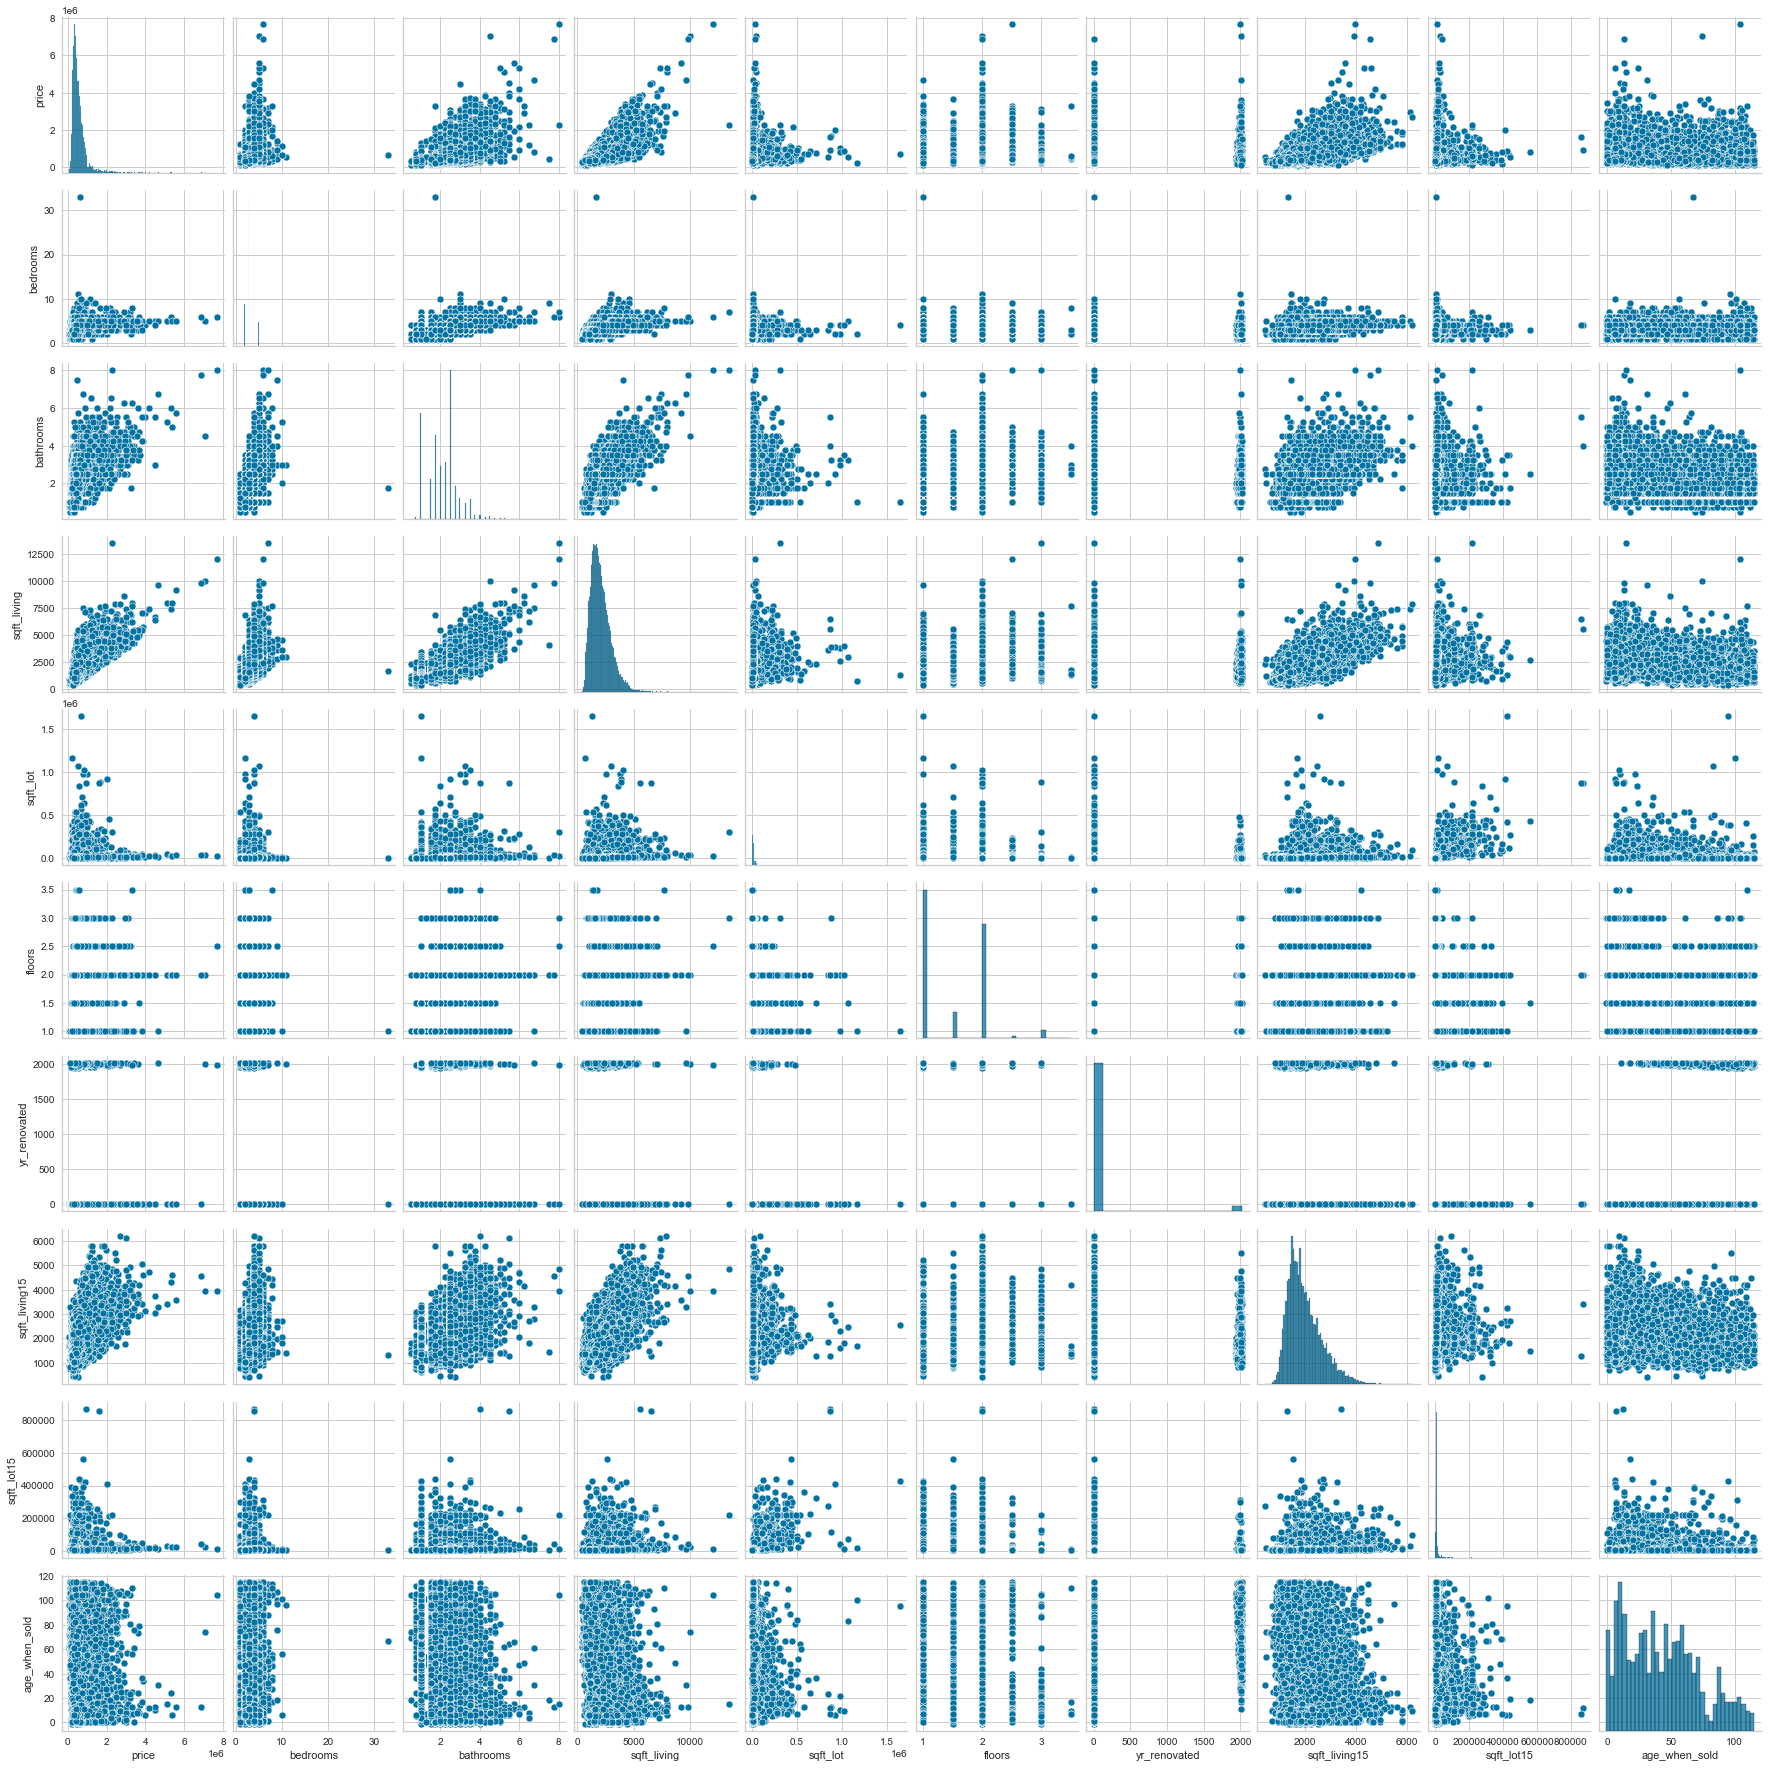

In [19]:
sns.pairplot(numerical_df)

In [20]:
# dropping numerical values that don't show linearity with price, as well as extraneous columns based on data processing above.
housing_df_clean = housing_df.drop(['id','date', 'sqft_lot15', 'sqft_lot', 'floors', 'grade','sqft_basement','sqft_above','yr_built', 'year_sold', 'yr_renovated', 'lat', 'long', 'age_when_sold'], axis=1)
housing_df_clean

,price,bedrooms,bathrooms,sqft_living,waterfront,view,condition,zipcode,sqft_living15,basement
0,221900.0,3,1.00,1180,NaN,NONE,Average,98178,1340,0
1,538000.0,3,2.25,2570,NO,NONE,Average,98125,1690,1
2,180000.0,2,1.00,770,NO,NONE,Average,98028,2720,0
3,604000.0,4,3.00,1960,NO,NONE,Very Good,98136,1360,1
4,510000.0,3,2.00,1680,NO,NONE,Average,98074,1800,0
...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,NO,NONE,Average,98103,1530,0
21593,400000.0,4,2.50,2310,NO,NONE,Average,98146,1830,0
21594,402101.0,2,0.75,1020,NO,NONE,Average,98144,1020,0
21595,400000.0,3,2.50,1600,NaN,NONE,Average,98027,1410,0


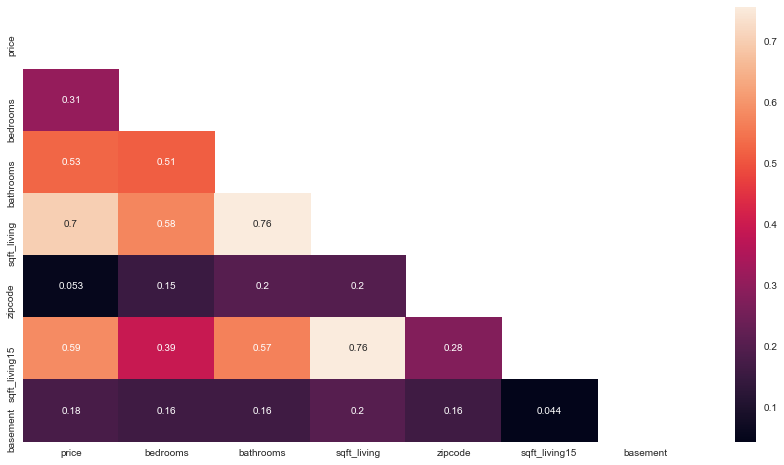

In [21]:
corr = abs(housing_df_clean.corr())
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), annot=True);

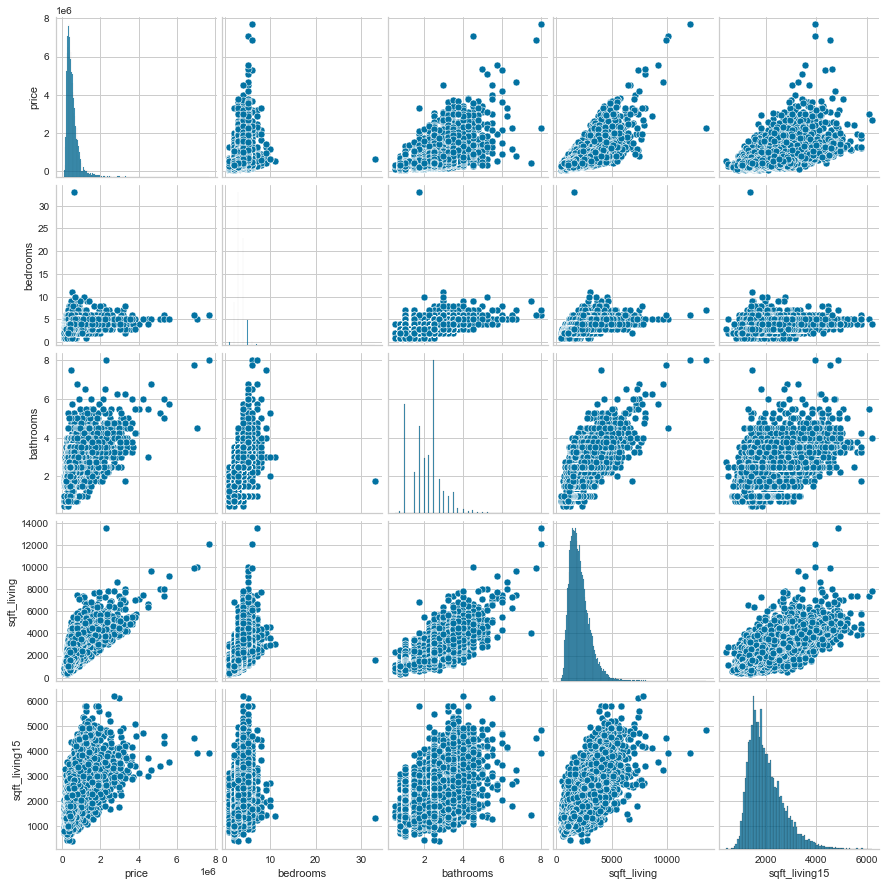

In [22]:
numerical_after_drop_df = housing_df_clean.drop(['waterfront', 'view', 'condition', 'zipcode', 'basement'], axis=1)
sns.pairplot(numerical_after_drop_df)

In [23]:
#start talking about pairplot interpretation here
# we can see how bedrooms has a minimal linear relationship to price. 
# let's keep it in for now, until we run a moedl and find the best coefficients. 

In [24]:
housing_df_clean.describe()

,price,bedrooms,bathrooms,sqft_living,zipcode,sqft_living15,basement
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,98077.951845,1986.620318,0.392971
std,3.673681e+05,0.926299,0.768984,918.106125,53.513072,685.230472,0.488422
min,7.800000e+04,1.000000,0.500000,370.000000,98001.000000,399.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,98033.000000,1490.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,98065.000000,1840.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,98118.000000,2360.000000,1.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,98199.000000,6210.000000,1.000000


In [25]:
#Filtering outliers to improve correlation and model
housing_df_clean['bathrooms'] = housing_df_clean['bathrooms'][housing_df_clean['bathrooms'].between(housing_df_clean['bathrooms'].quantile(.005), housing_df_clean['bathrooms'].quantile(.995), inclusive=True)]
housing_df_clean['bedrooms'] = housing_df_clean['bedrooms'][housing_df_clean['bedrooms'].between(housing_df_clean['bedrooms'].quantile(.005), housing_df_clean['bedrooms'].quantile(.995), inclusive=True)]
housing_df_clean['sqft_living'] = housing_df_clean['sqft_living'][housing_df_clean['sqft_living'].between(housing_df_clean['sqft_living'].quantile(.005), housing_df_clean['sqft_living'].quantile(.995), inclusive=True)]

In [26]:
housing_df_clean.isna().sum()

price               0
bedrooms           62
bathrooms         162
sqft_living       196
waterfront       2376
view               63
condition           0
zipcode             0
sqft_living15       0
basement            0
dtype: int64

In [27]:
X = housing_df_clean.drop(columns = 'price', axis=1)
y = housing_df_clean['price']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
X_train.isna().sum()

bedrooms           48
bathrooms         109
sqft_living       132
waterfront       1556
view               42
condition           0
zipcode             0
sqft_living15       0
basement            0
dtype: int64

In [30]:
view_col = X_train[['view']]
imputer_view = SimpleImputer(strategy='constant', fill_value = 'NONE')
imputer_view.fit(view_col)
view_imputed = imputer_view.transform(view_col)
X_train.view = view_imputed

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:
view_col = X_test[['view']]
view_imputed = imputer_view.transform(view_col)
X_test.view = view_imputed

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [32]:
water_col = X_train[['waterfront']]
imputer_water = SimpleImputer(strategy='constant', fill_value = 'NO')
imputer_water.fit(water_col)
waterfront_imputed = imputer_water.transform(water_col)
X_train.waterfront = waterfront_imputed

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:
water_col = X_test[['waterfront']]
waterfront_test_imputed = imputer_water.transform(water_col)
X_test.waterfront = waterfront_test_imputed

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [34]:
cat_cols = [ 'waterfront', 'view', 'condition', 'zipcode']
cat_cols

['waterfront', 'view', 'condition', 'zipcode']

In [35]:
X_train.isna().sum()

bedrooms          48
bathrooms        109
sqft_living      132
waterfront         0
view               0
condition          0
zipcode            0
sqft_living15      0
basement           0
dtype: int64

In [36]:
X_train.dropna(inplace=True)

<ipython-input-36-c608130e58c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.dropna(inplace=True)


In [37]:
X_train.isna().sum()

bedrooms         0
bathrooms        0
sqft_living      0
waterfront       0
view             0
condition        0
zipcode          0
sqft_living15    0
basement         0
dtype: int64

In [38]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')
ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [39]:
X_train_enc = pd.DataFrame(X_train_enc.todense(), index=X_train.index, columns= ct.get_feature_names())

In [40]:
X_test_enc = pd.DataFrame(X_test_enc.todense(), index=X_test.index, columns= ct.get_feature_names())

In [41]:
# intstantiate our scaler
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_enc)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [42]:
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index ,columns= ct.get_feature_names())

In [43]:
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns= ct.get_feature_names())

In [44]:
view_col = X_train[['view']]
encoder_view = OrdinalEncoder(categories=[["NONE","FAIR", "AVERAGE", "GOOD", "EXCELLENT"]])
encoder_view.fit(view_col)
encoded_view = encoder_view.transform(view_col)
encoded_view = encoded_view.flatten()
X_train.view = encoded_view

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [45]:
encoder_view.categories_

[array(['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'], dtype=object)]

In [46]:
view_col = X_test[['view']]
encoded_view = encoder_view.transform(view_col)
encoded_view = encoded_view.flatten()
X_test.view = encoded_view

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [47]:
water_col = X_train[['waterfront']]
encoder_water = OrdinalEncoder()
encoder_water.fit(water_col)
encoded_water = encoder_water.transform(water_col)
encoded_water = encoded_water.flatten()
X_train.waterfront = encoded_water

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
water_col = X_test[['waterfront']]
encoded_water = encoder_water.transform(water_col)
encoded_water = encoded_water.flatten()
X_test.waterfront = encoded_water

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [49]:
cat_cols_ordinal = ['condition', 'zipcode']
cat_cols_ordinal

['condition', 'zipcode']

In [50]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols_ordinal)],
                       remainder='passthrough')
ct.fit(X_train)
X_train_ord = ct.transform(X_train)
X_test_ord = ct.transform(X_test)

In [51]:
X_train_ord = pd.DataFrame(X_train_ord.todense(), index=X_train.index, columns= ct.get_feature_names())

In [52]:
X_test_ord = pd.DataFrame(X_test_ord.todense(), index=X_test.index, columns= ct.get_feature_names())

In [53]:
# intstantiate our scaler
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_ord)

# transform both train and test data
X_train_scaled_ord = scaler.transform(X_train_ord)
X_test_scaled_ord = scaler.transform(X_test_ord)

In [54]:
X_train_scaled_ord = pd.DataFrame(X_train_scaled_ord, index=X_train.index, columns= ct.get_feature_names())

In [55]:
X_test_scaled_ord = pd.DataFrame(X_test_scaled_ord, index=X_test.index, columns= ct.get_feature_names())

In [56]:
# function to generate error 
def res_plots(model, X_train, X_test, y_train, y_test):
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_resids = y_train - train_preds
    test_resids = y_test - test_preds
    
    durbinWatson = durbin_watson(test_resids)
    
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    test_rmse = mean_squared_error(y_test, test_preds, squared=False)
    
    bins = int(  len(X_test)**.5 )
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(9, 18), nrows=3)
    sns.histplot(test_resids, bins=bins, kde=True, ax=ax1)
    sm.qqplot(test_resids, line='r', ax=ax2)
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    
    plt.show()
    print(f'R2_train: {r2_score(y_train, train_preds):.3f}'),\
    print(f'R2_test: {r2_score(y_test, test_preds):.3f}'),\
    print(f'Durbin-Watson: {durbinWatson:.3f}'),\
    print(f'Train Mean Squarred Error: {train_mse:.3f}'),\
    print(f'Test Mean Squarred Error: {test_mse:.3f}'),\
    print(f'Test RMSE: {test_rmse:.3f}')
    

In [57]:
def res_plots_log(model, X_train, X_test, y_train, y_test):
    
    train_preds = np.exp(model.predict(X_train))
    test_preds = np.exp(model.predict(X_test))
    train_resids = np.exp(y_train) - train_preds
    test_resids = np.exp(y_test) - test_preds
    
    durbinWatson = durbin_watson(test_resids)
    
    train_mse = mean_squared_error(np.exp(y_train), train_preds)
    test_mse = mean_squared_error(np.exp(y_test), test_preds)
    test_rmse = mean_squared_error(np.exp(y_test), test_preds, squared=False)
    
    bins = int(  len(X_test)**.5 )
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(9, 18), nrows=3)
    sns.histplot(test_resids, bins=bins, kde=True, ax=ax1)
    sm.qqplot(test_resids, line='r', ax=ax2)
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    
    plt.show()
    print(f'R2_train: {r2_score(y_train, np.log(train_preds)):.3f}'),\
    print(f'R2_test: {r2_score(y_test, np.log(test_preds)):.3f}'),\
    print(f'Durbin-Watson: {durbinWatson:.3f}'),\
    print(f'Train Mean Squarred Error: {train_mse:.3f}'),\
    print(f'Test Mean Squarred Error: {test_mse:.3f}'),\
    print(f'Test RMSE: {test_rmse:.3f}')

In [61]:
X_train.shape

(14228, 9)

In [62]:
y_train.shape

(14469,)

In [58]:
# Setting up our dummy regressor
dummy_regr = DummyRegressor()
dummy_regr.fit(X_train, y_train)
print(dummy_regr.score(X_train, y_train))
print(dummy_regr.score(X_test, y_test))

ValueError: Found input variables with inconsistent numbers of samples: [14228, 14469]

In [59]:
# first simple model

col_use = ['sqft_living']
fsm_model = LinearRegression()
fsm_model.fit(X_train_scaled[col_use], y_train)
print(fsm_model.score(X_train_scaled[col_use], y_train))
print(fsm_model.score(X_test_scaled[col_use], y_test))

ValueError: Found input variables with inconsistent numbers of samples: [14228, 14469]

In [ ]:
fsm_model_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled[col_use]))
fsm_model_ols.fit().summary()

In [ ]:
res_plots(fsm_model, X_train_scaled[col_use], X_test_scaled[col_use], y_train, y_test)

In [ ]:
# model with no encoders
col_use = ['sqft_living','bedrooms','bathrooms','sqft_living15', 'basement']
mlr_1 = LinearRegression()
mlr_1.fit(X_train_scaled[col_use], y_train)
print(mlr_1.score(X_train_scaled[col_use], y_train))
print(mlr_1.score(X_test_scaled[col_use], y_test))

In [ ]:
mlr_1_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled[col_use]))
mlr_1_ols.fit().summary()

In [ ]:
res_plots(mlr_1, X_train_scaled[col_use], X_test_scaled[col_use], y_train, y_test)

In [ ]:
#model with no encoders and log of price 
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = ['sqft_living','bedrooms','bathrooms','sqft_living15', 'basement',]
mlr_2 = LinearRegression()
mlr_2.fit(X_train_scaled[col_use], y_train_log)
print(mlr_2.score(X_train_scaled[col_use], y_train_log))
print(mlr_2.score(X_test_scaled[col_use], y_test_log))

In [ ]:
mlr_2_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled[col_use]))
mlr_2_ols.fit().summary()

In [ ]:
res_plots_log(mlr_2, X_train_scaled[col_use], X_test_scaled[col_use], y_train_log, y_test_log)

In [ ]:
# model with just waterfront and view ordinal encoder 
col_use = ['sqft_living','bedrooms','bathrooms','sqft_living15', 'basement','view', 'waterfront']
mlr_3 = LinearRegression()
mlr_3.fit(X_train_scaled_ord[col_use], y_train)
print(mlr_3.score(X_train_scaled_ord[col_use], y_train))
print(mlr_3.score(X_test_scaled_ord[col_use], y_test))

In [ ]:
mlr_3_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled_ord[col_use]))
mlr_3_ols.fit().summary()

In [ ]:
res_plots(mlr_3, X_train_scaled_ord[col_use], X_test_scaled_ord[col_use], y_train, y_test)

In [ ]:
# model with ohe 
col_use = X_train_scaled
mlr_4 = LinearRegression()
mlr_4.fit(X_train_scaled, y_train)
print(mlr_4.score(X_train_scaled, y_train))
print(mlr_4.score(X_test_scaled, y_test))

In [ ]:
mlr_4_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled))
mlr_4_ols.fit().summary()

In [ ]:
res_plots(mlr_4, X_train_scaled, X_test_scaled, y_train, y_test)

In [ ]:
# model with ohe and ordinal encoders 
col_use = X_train_scaled_ord
mlr_5 = LinearRegression()
mlr_5.fit(X_train_scaled_ord, y_train)
print(mlr_5.score(X_train_scaled_ord, y_train))
print(mlr_5.score(X_test_scaled_ord, y_test))

In [ ]:
mlr_5_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled_ord))
mlr_5_ols.fit().summary()

In [ ]:
res_plots(mlr_5, X_train_scaled_ord, X_test_scaled_ord, y_train, y_test)

In [ ]:
# model with ohe and ordinal encoders and log price, before RFE

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = X_train_scaled_ord
mlr_6 = LinearRegression()
mlr_6.fit(X_train_scaled_ord, y_train_log)
print(mlr_6.score(X_train_scaled_ord, y_train_log))
print(mlr_6.score(X_test_scaled_ord, y_test_log))

In [ ]:
mlr_6_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled_ord))
mlr_6_ols.fit().summary()

In [ ]:
res_plots_log(mlr_6, X_train_scaled_ord, X_test_scaled_ord, y_train_log, y_test_log)

In [ ]:
# Make a new model to explore how each feature impacts the model
mlr_6_rfe = LinearRegression()

# Instantiate our RFE with that new model and how many features we want, first cutting features in half
rfe = RFE(mlr_6_rfe, n_features_to_select=40)

# Fit to our polynomial training data
rfe.fit(X_train_scaled_ord, y_train_log)

In [ ]:
rfe_selectors = []

for col_name, support in dict(zip(X_train_scaled_ord.columns, rfe.support_)).items():
    if support == True:
        rfe_selectors.append(col_name)


In [ ]:
# model with ohe and ordinal encoders and log price, but with top half of variables through RFE

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = X_train_scaled_ord[rfe_selectors]
mlr_7 = LinearRegression()
mlr_7.fit(X_train_scaled_ord[rfe_selectors], y_train_log)
print(mlr_7.score(X_train_scaled_ord[rfe_selectors], y_train_log))
print(mlr_7.score(X_test_scaled_ord[rfe_selectors], y_test_log))

In [ ]:
mlr_7_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled_ord[rfe_selectors]))
mlr_7_ols.fit().summary()

In [ ]:
res_plots_log(mlr_7, X_train_scaled_ord[rfe_selectors], X_test_scaled_ord[rfe_selectors], y_train_log, y_test_log)

In [ ]:
# Make a new model to explore how each feature impacts the model
mlr_7_rfe = LinearRegression()

# Instantiate our RFE with that new model and how many features we want but we found top 10 
rfe = RFE(mlr_7_rfe, n_features_to_select=10)

# Fit to our polynomial training data
rfe.fit(X_train_scaled_ord, y_train_log)

In [ ]:
rfe_selectors = []

for col_name, support in dict(zip(X_train_scaled_ord.columns, rfe.support_)).items():
    if support == True:
        rfe_selectors.append(col_name)


In [ ]:
# model with ohe and ordinal encoders and log price, but with top 10 through RFE

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = X_train_scaled_ord[rfe_selectors]
mlr_8 = LinearRegression()
mlr_8.fit(X_train_scaled_ord[rfe_selectors], y_train_log)
print(mlr_8.score(X_train_scaled_ord[rfe_selectors], y_train_log))
print(mlr_8.score(X_test_scaled_ord[rfe_selectors], y_test_log))

In [ ]:
mlr_8_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled_ord[rfe_selectors]))
mlr_8_ols.fit().summary()

In [ ]:
# R2 value significantly lower, this is why we want to include all the zipcodes. 

In [ ]:
col_use = ['sqft_living','bedrooms','bathrooms','sqft_living15', 'basement','view', 'waterfront']
mlr_8_rfe = LinearRegression()

rfe = RFE(mlr_8_rfe, n_features_to_select=5)

rfe.fit(X_train_scaled_ord[col_use], y_train)

In [ ]:
rfe_selectors = []

for col_name, support in dict(zip(X_train_scaled_ord[col_use].columns, rfe.support_)).items():
    if support == True:
        rfe_selectors.append(col_name)
rfe_selectors

In [ ]:
# this tells us to drop bathrooms and basement 
# notice how in the sns plot above, bedrooms were the least linear. makes sense to drop it. 

In [ ]:
X_train_scaled_ord = X_train_scaled_ord.drop(columns= ['bedrooms','basement'])
X_test_scaled_ord = X_test_scaled_ord.drop(columns= ['bedrooms','basement'])

In [ ]:
# model with ohe and ordinal encoders and log price, all the zipcodes,
# and with dropped numerical 'bedrooms' and 'basement' columns through RFE 
#this is our final predictive model

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = X_train_scaled_ord
mlr_9 = LinearRegression()
mlr_9.fit(X_train_scaled_ord, y_train_log)
print(mlr_9.score(X_train_scaled_ord, y_train_log))
print(mlr_9.score(X_test_scaled_ord, y_test_log))

In [ ]:
mlr_9_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled_ord))
mlr_9_ols.fit().summary()

In [ ]:
res_plots_log(mlr_9, X_train_scaled_ord, X_test_scaled_ord, y_train_log, y_test_log)

In [ ]:
X_train_enc = X_train_enc.drop(columns= ['bedrooms','basement'])
X_test_enc = X_test_enc.drop(columns= ['bedrooms','basement'])

In [ ]:
# use this for inferrencial
# un-loged and un-scaled 
col_use = X_train_enc
mlr_10_unscaled = LinearRegression()
mlr_10_unscaled.fit(X_train_enc, y_train)
print(mlr_10_unscaled.score(X_train_enc, y_train))
print(mlr_10_unscaled.score(X_test_enc, y_test))

In [ ]:
mlr_10_unscaled_ols = sm.OLS(y_train, sm.add_constant(X_train_enc))
mlr_10_unscaled_ols.fit().summary()

In [ ]:
# $170 increase in price per 1 sqft increase
# $61 increase in price per 1 sqft increase in nearest 15 neighbors
# $9,344 increase in price per 1 bathroom increase
# $516,600 increase in price if waterfront 
# $73,020 decrease in price if no view
# $15,880 increase in price if fair view
# $101,400 increase in price if good view
# $258,900 increase in price if excellent view
 


In [ ]:
res_plots(mlr_10_unscaled, X_train_enc, X_test_enc, y_train, y_test)

In [ ]:
concat_train = pd.concat([X_train_ord[['bathrooms', 'sqft_living', 'waterfront', 'view', 'sqft_living15']], y_train], axis=1)

In [ ]:
concat_test = pd.concat([X_test_ord[['bathrooms', 'sqft_living', 'waterfront', 'view', 'sqft_living15']], y_test], axis=1)

In [ ]:
visualization_df = pd.concat([concat_train, concat_test])
visualization_df

In [ ]:
# categorical features
    
fig, ax = plt.subplots()
    
sns.barplot('waterfront', 'price', data=visualization_df, ci=None),
ax.set_yticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000', '1,400,000', '1,600,000', '1,800,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xticklabels(['No', 'Yes'])
ax.set_xlabel('Waterfront', labelpad=20)
ax.grid(False)
ax.set_title('Waterfront Feature', pad=20)
plt.savefig('Images/waterfront_bar.png', bbox_inches='tight')

plt.show()

In [ ]:
fig, ax = plt.subplots()
    
sns.barplot('view', 'price', data=visualization_df, ci=None),
ax.set_yticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000', '1,400,000', '1,600,000', '1,800,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xticklabels(['None', 'Fair', 'Average', 'Good', 'Excellent'])
ax.set_xlabel('View', labelpad=20)
ax.grid(False)
ax.set_title('View Feature', pad=20)
plt.savefig('Images/view_bar.png', bbox_inches='tight')

plt.show()

In [ ]:
fig, ax = plt.subplots()
    
sns.barplot('bathrooms', 'price', data=visualization_df, ci=None),
ax.set_yticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000', '1,400,000', '1,600,000', '1,800,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xticklabels(['1', '1.25', '1.5', '1.75', '2', '2.25', '2.5', '2.75', '3', '3.25', '3.5', '3.75', '4', '4.25','4.5'])
ax.set_xlabel('Bathrooms', labelpad=20)
ax.grid(False)
ax.set_title('Bathroom Feature', pad=20)
plt.savefig('Images/bathroom_bar.png', bbox_inches='tight')

plt.show()

In [ ]:
# numerical features

fig, ax = plt.subplots()
    
sns.regplot('sqft_living', 'price', data=visualization_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
ax.set_yticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000', '4,000,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xlabel('Sqft of Living Area', labelpad=20)
ax.grid(False)
ax.set_title('Living Area Feature', pad=20)
plt.savefig('Images/sqft_living_regplot.png', bbox_inches='tight')

plt.show()

In [ ]:
fig, ax = plt.subplots()
    
sns.regplot('sqft_living15', 'price', data=visualization_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
ax.set_yticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000', '4,000,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xlabel('Sqft of Living Area of 15 Nearest Neighbors', labelpad=20)
ax.grid(False)
ax.set_title('Nearest Neighbor Feature', pad=20)
plt.savefig('Images/sqft_living15_regplot.png', bbox_inches='tight')

plt.show()

In [ ]:
# inferencial: looking at coefficients, and which make the biggest impact on price, and by how much. 
# talk about specific coefficients/variables and how they affect price per 1 unit increase
# if these are the features we pick, talk about how a 1 unite increase in blank will yield an x increase in price
# use coefficients
# breaking assumptions?
# you can violate assumptions and still have a decent predictive model. 
# If you violate assumptions, your inferencial model is less robust your coefficient interpretation. 

In [ ]:
# predictive: R2 value and RMSE 
# want a higher R2 in general. want difference between R2_train and R2_test to be neglible. 
# want RMSE to be lower, less dollars you're off by. Compare this RMSE to RMSE of other models. 

In [ ]:
#in conclusion, how does model offer competitive edge? include in slide. be more specific in recommendations 